In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
from stable_baselines3 import PPO
import os
import datetime
from argparse import ArgumentParser
from pathlib import Path
from simply import market, market_2pac, market_fair, actor
from simply.scenario import load, create_random, Scenario
from simply.config import Config
from simply.util import summerize_actor_trading
from simplyrl import energy_env, rl_agent
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from match_market import main
from pathlib import Path
from argparse import ArgumentParser

from simply import market, market_2pac, market_fair
from simply.scenario import load, create_random, Scenario
from simply.config import Config
from simply.actor import Actor
from simply.market_maker import MarketMaker

import os
import time

In [2]:
algorithm = "new_start/24/1.4/norm_bank_reward_04-03-21-4"
# algorithm = "new_start/24/1.4/norm_bank_reward_new"
results_dir = f"rl-models/{algorithm}/benchmarks"

In [3]:
project_dir = "/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/projects/rl_test_single"

In [4]:
# This means that the config file must always be in the project directory
config_file = os.path.join(project_dir, "config.cfg")
# Raise error if config.(cfg|txt) file not found in project directory
if not os.path.isfile(config_file):
    config_file = os.path.join(project_dir, "config.txt")
    if not os.path.isfile(config_file):
        raise (FileNotFoundError(
            f"Config file not found in project directory: {project_dir}"))
cfg = Config(config_file, project_dir)
cfg.train_rl = False
# sc = main(cfg)
# sim_time = (time.time() - start_time)
# if sim_time > 120:
#     mins, secs = divmod(sim_time, 60)
#     print(f'It took {int(mins)} minutes and {int(secs)} seconds to execute simulation.')
# else:
#     print(f'It took {sim_time:.3f} seconds to execute simulation.')

In [69]:
sc.market_participants[0].all_buy_prices

array([0.05087, 0.05087, 0.05087, ..., 0.05096, 0.05096, 0.04912])

In [5]:
def run_testing(cfg):
    """
    runs tests on common dataset to provide performance measure for RL training progress
    @param cfg: config file for
    @return: 
    """
    pretrained_model = cfg.pretrained_model
    intervals, _ = divmod(cfg.nb_ts, cfg.training_interval)
    # intervals = 3

    models = list(range(int(pretrained_model), int(pretrained_model) + 2048*intervals, 2048))
    cfg.train_rl = False
    REWARDS = {} 
    ENERGY = {}
    PVS = {}
    LOADS = {}
    SOCS = {}
    BANKS = {}
    for version in models:
        cfg.pretrained_model = str(version)
        sc = main(cfg)
        print(f"-----------Test run model {version} is completed. Logging data.")
        # find participant that is RL agent, only works with ONE Rl agent
        for participant in sc.market_participants:
            if isinstance(participant, Actor):
                if participant.strategy == 4:
                    REWARDS[str(version)] = participant.rewards
                    ENERGY[str(version)] = participant.matched_energies
                    PVS[str(version)] = participant.data.pv
                    LOADS[str(version)] = participant.data.load
                    SOCS[str(version)] = participant.socs
                    BANKS[str(version)] = participant.rl_bank
            elif isinstance(participant, MarketMaker):
                MARKET_PRICES = participant.all_buy_prices
    
    return REWARDS, ENERGY, MARKET_PRICES, PVS, LOADS, SOCS, BANKS

In [ ]:
REWARDS, ENERGY, MARKET_PRICES, PVS, LOADS, SOCS, BANKS = run_testing(cfg)

In [ ]:
# buying energy as well as pv have positive sign
# selling energy has negative sign

In [7]:
rewards_df = pd.DataFrame.from_dict(REWARDS)
energy_df = pd.DataFrame.from_dict(ENERGY)
market_prices_df = pd.DataFrame(MARKET_PRICES, columns=["market_price"])
pvs_df = pd.DataFrame.from_dict(PVS)
loads_df = pd.DataFrame.from_dict(LOADS)
socs_df = pd.DataFrame.from_dict(SOCS)
banks_df = pd.DataFrame.from_dict(BANKS, orient="index", columns=["profit"])

In [8]:
market_prices_df

,market_price
0,0.05087
1,0.05087
2,0.05087
3,0.05087
4,0.04819
...,...
1020,0.05096
1021,0.05096
1022,0.05096
1023,0.05096


In [9]:
def visualise_performance(rewards_df, socs_df, banks_df, intervals):
    
    # Create a figure and axis object
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))
    
    # Create the boxplot
    sns.boxplot(data=rewards_df, ax=ax1, showfliers=False)
    
    # create linechart for Bank and Battery SoC after interval
    banks_df.plot(ax=ax2, marker="x")
    socs_df.plot(ax=ax3)
    
    # Label the y-axis
    ax1.set_ylabel('Rewards in training interval')
    ax2.set_ylabel('Bank profits in training interval')
    ax3.set_ylabel('Battery SoC in training interval')
    
    # Set x-axis label and ticks
    ax3.set_xlabel("timesteps")
    ax3.xaxis.set_ticks(np.arange(0, len(socs_df)+1, len(socs_df)/10))
    
    # Rotate the xticklabels by 90 degrees
    xtick_labels = [f"Model {mod}" for mod in rewards_df.columns]
    ax1.set_xticks(list(range(intervals)), xtick_labels, rotation=45, ha="right")
    xtick_labels = [f"Model {mod}" for mod in banks_df.index]
    ax2.set_xticks(list(range(intervals)), xtick_labels, rotation=45, ha="right")
    
    # Add grid lines
    ax1.yaxis.grid(True)
    ax2.yaxis.grid(True)
    ax3.yaxis.grid(True)
    
    # show legend for linecharts
    # ax2.legend(loc="upper center")
    ax3.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    
    # Show the plot
    fig.suptitle('Comparison of agents performance in different intervals')
    fig.tight_layout()
    # datetime object containing current date and time
    now = datetime.now()

    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
    fig.savefig(f'{results_dir}/performance_test_{dt_string}.png', dpi=300)
    plt.show()

In [17]:
def visulaize_trading_behaviour(energy_df, market_prices_df, pvs_df, loads_df, socs_df, n_ts, seed, interval):
    
    # choose random interval of length n_ts for plotting behaviour
    np.random.seed(seed)
    t_start = np.random.choice(list(range(len(market_prices_df.iloc[:,0])-n_ts)))
    # select data
    energy = energy_df.iloc[t_start:t_start+n_ts,interval-1]
    market_prices = market_prices_df.iloc[t_start:t_start+n_ts,0]
    pv = pvs_df.iloc[t_start:t_start+n_ts,interval-1]
    battery = socs_df.iloc[t_start:t_start+n_ts,interval-1] * 13.5
    load = loads_df.iloc[t_start:t_start+n_ts,interval-1]
    
     # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(16, 9))
    
    ax2 = ax.twinx()
    
    # create linechart for energy, market prices and actor pv and load
    energy.plot(ax=ax, linestyle="solid", label="energy", color="#2c777a")
    market_prices.plot(ax=ax2, linestyle="dashed", label="market_price", color="#800020")
    pv.plot(ax=ax, linestyle="solid", label="pv",color="#fff16a")
    battery.plot(ax=ax, linestyle="solid", label="battery",color="#47dc7a", alpha=0.3)
    load.plot(ax=ax, linestyle="dashdot", label="load", color="#2e313f")
    
    # added these three lines
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    # Label the y-axis
    ax.set_ylabel("Energy in kWh")
    ax2.set_ylabel("Price in €/kWh")
    market_prices_range = market_prices.max()*1.2 - market_prices.min()
    ax2.set_ylim(market_prices.min() - market_prices_range, market_prices.min() + market_prices_range)
    
    # Set x-axis label and ticks
    ax.set_xlabel("timesteps")
    ax.xaxis.set_ticks(np.arange(t_start, t_start+n_ts+1, n_ts/12))
    
    # Add grid lines
    ax.yaxis.grid(True)
    
    # show legend for linecharts
    ax.legend(lines + lines2, labels + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    
    # Show the plot
    fig.suptitle(f'Trading behaviour of rl model {pvs_df.columns[interval-1]}')
    fig.tight_layout()
    # datetime object containing current date and time
    now = datetime.now()
    
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
    fig.savefig(f'{results_dir}/trading_behaviour_test_{dt_string}.png', dpi=300)
    plt.show()


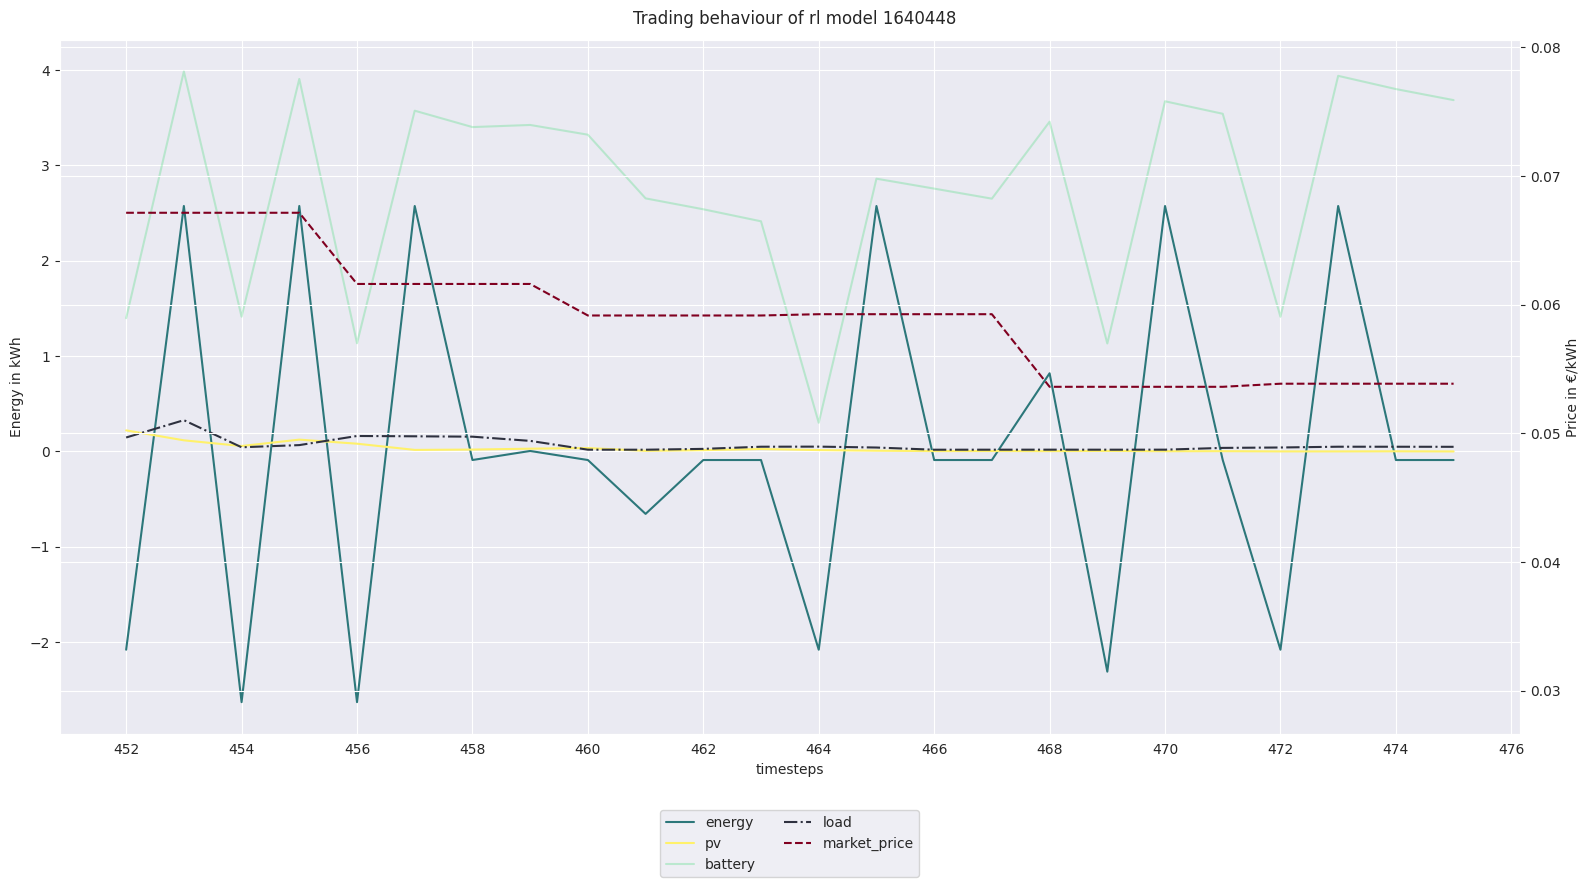

In [18]:
visulaize_trading_behaviour(energy_df, market_prices_df, pvs_df, loads_df, socs_df, 24, seed=533, interval=1)

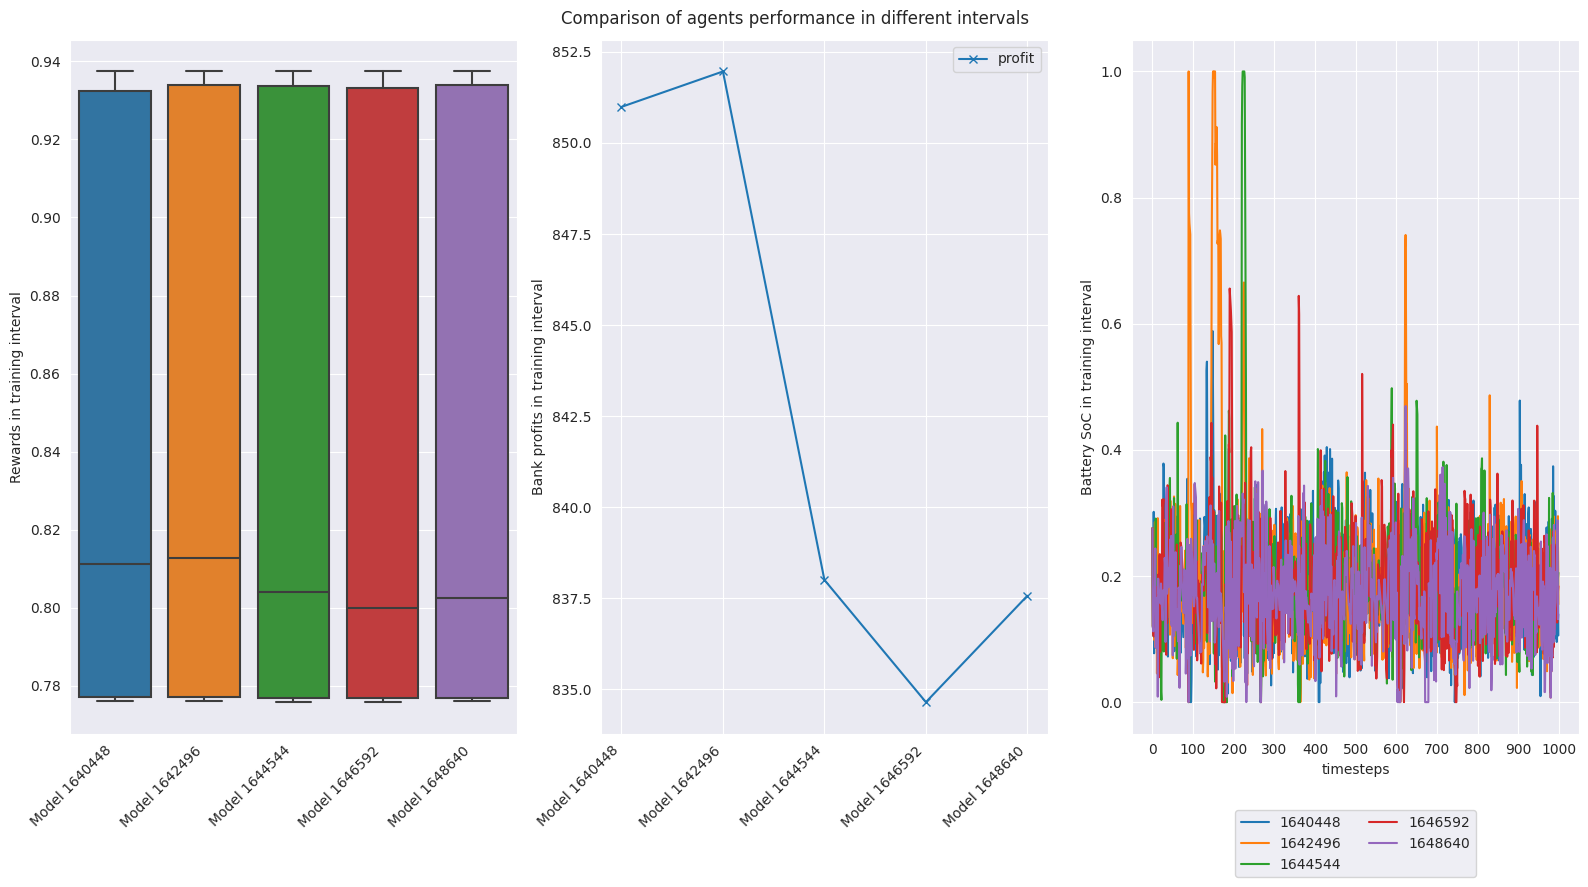

In [50]:
sualise_performance(rewards_df=rewards_df, energy_df=energy_df, socs_df=socs_df, banks_df=banks_df, intervals=intervals)

In [2]:
df = pd.read_csv("scenarios/rl_testing4/orders.csv")

In [7]:
import matplotlib.pyplot as plt

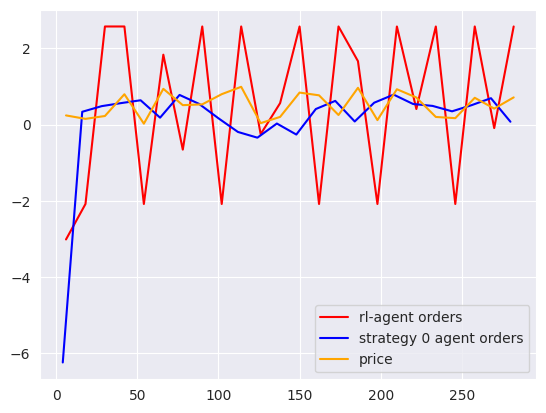

In [29]:
fig,ax = plt.subplots()
ax.plot(-df.loc[df.actor_id == "H4"].type * df.loc[df.actor_id == "H4"].energy, color = "red", label="rl-agent orders")
ax.plot(-df.loc[df.actor_id == "H2"].type * df.loc[df.actor_id == "H2"].energy, color = "blue", label="strategy 0 agent orders")
ax.plot(df.loc[df.actor_id == "H4"].price, color="orange", label="price")
ax.legend();

In [2]:
def predict_agent(actor=None, algorithm=None, best_timestep=None, horizon=24):

    env = actor.rl_environment
    # load RL model to create market schedule prediction
    models_dir = f"rl-models/{algorithm}"
    model_path = f"{models_dir}/{best_timestep}"

    model = PPO.load(model_path, env=env)

    observation = env.reset()

    action = model.predict(observation)
    next_action = round(env.action_energy_values[action[0]], 3)

    return next_action

In [3]:
parser = ArgumentParser(description='Entry point for market simulation')
parser.add_argument('config', nargs='?', default="", help='configuration file')
args, unknown = parser.parse_known_args("confgi_test.cfg")
cfg = Config(args.config)

/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/simply/config.py:54: UserWarning: c was provided as Configuration file, but this file does not exist. Default values will be used.
  warnings.warn(f"{cfg_file} was provided as Configuration file, but this file does not "


Scenario path: scenarios/default


/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/simply/market_maker.py:86: UserWarning: Market Maker selling prices are set equal to buying prices
  warnings.warn("Market Maker selling prices are set equal to buying prices")
/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/simply/actor.py:855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day["pv"] *= gaussian_pv(ts_hour, 3)
/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/simply/actor.py:855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

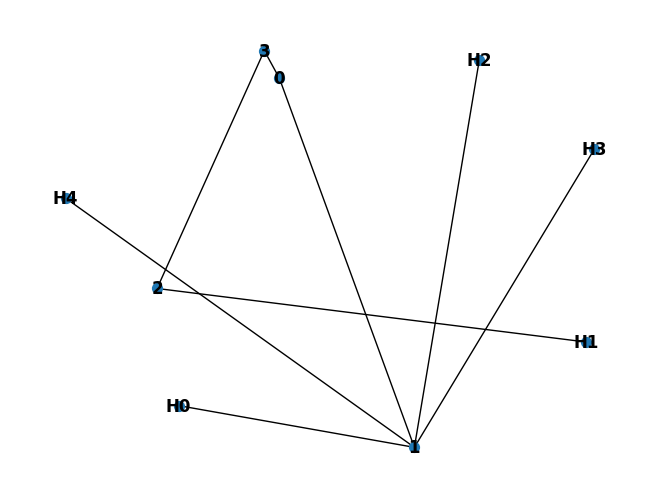

In [4]:
scenario_exists = len([False for i in cfg.path.glob(f"actor_*.{cfg.data_format}")]) != 0

print(f'Scenario path: {cfg.path}')

# load existing scenario or else create randomized new one
sc: Scenario
if cfg.load_scenario:
    if scenario_exists:
        sc = load(cfg.path, cfg.data_format)
    else:
        raise Exception(f'Could not find actor data in path: {cfg.path} .')
else:
    if cfg.path.exists():
        raise Exception(f'The path: {cfg.path} already exists with another file structure. '
                        'Please remove or rename folder to avoid confusion and restart '
                        'simulation.')
    else:
        # create path if it does not exist yet
        cfg.path.mkdir(parents=True, exist_ok=True)
    sc = create_random(cfg.nb_nodes, cfg.nb_actors, cfg.weight_factor)
    sc.save(cfg.path, cfg.data_format)

if cfg.show_plots:
    sc.power_network.plot()
    sc.plot_participant_data()

# generate requested market
if "pac" in cfg.market_type:
    m = market_2pac.TwoSidedPayAsClear(network=sc.power_network)
elif cfg.market_type in ["fair", "merit"]:
    m = market_fair.BestMarket(network=sc.power_network)
else:
    # default
    m = market.Market(network=sc.power_network)

sc.add_market(m)
# for _ in range(cfg.nb_ts):
#     # actors calculate strategy based market interaction with the market maker
#     sc.create_strategies()
# 
#     # orders are generated based on the flexibility towards the planned market interaction
#     # and a pricing scheme. Orders are matched at the end
#     sc.market_step()
# 
#     # actors are prepared for the next time step by changing socs, banks and predictions
#     sc.next_time_step()
# 
#     if cfg.show_prints:
#         print("Matches of bid/ask ids: {}".format(m.matches))
#         print(
#             "\nCheck individual traded energy blocks (splitted) and price at market level"
#         )
# 
# if cfg.show_prints:
#     print("\nTraded energy volume and price at actor level")
#     print(summerize_actor_trading(sc))

In [5]:
rl_actor = sc.market_participants[1]

In [44]:
def init_actor_df():
    actor_df = pd.read_csv('~/rli/BEST_local/filesFromEmil/sample/aggregated_df2.csv')
    LOAD_DATA = {}
    PV_DATA = {}
    PRICE_DATA = {}
    for i in range(24):
        load_list = []
        pv_list = []
        price_list = []
        for j in range(365):
            load_list.append(actor_df['load'][i + j*24])
            pv_list.append(actor_df['pv'][i + j*24])
            price_list.append(actor_df['prices'][i + j*24])

        LOAD_DATA[i] = load_list
        PV_DATA[i] = pv_list
        PRICE_DATA[i] = price_list
    return actor_df, LOAD_DATA, PV_DATA, PRICE_DATA

REAL_DF, LOAD_DATA, PV_DATA, PRICE_DATA = init_actor_df()

In [45]:
def create_synthetic_dataframe(horizon=8760, start=None):
    """
    Creates a random dataframe with 24 hours of data
    """
    realistic_load = []
    realistic_pv = []
    realistic_price = []
    for j in range(365):
        for i in range(24):
            realistic_load.append(generate_new_data_empirical(LOAD_DATA[i], 1)[0])
            realistic_pv.append(generate_new_data_empirical(PV_DATA[i], 1)[0])
            realistic_price.append(generate_new_data_empirical(PRICE_DATA[i], 1)[0])
    
    df = pd.DataFrame({'load': realistic_load, 'pv': realistic_pv, 'prices': realistic_price})
    
     # Add noise to each variable
    for var in ['load', 'pv', 'prices']:
        noise = np.random.normal(0, 0.002, 1)
        df[var] += noise

    if not start:
        start = np.random.randint(0, 8760-(horizon-1))

    df = df[start:start+horizon]
    df['schedule'] = df['pv'] - df['load']
    return df

In [46]:
def generate_new_data_empirical(data_list, num_samples):
    """
    Generate a new list of data that matches the empirical distribution of an existing list of data.

    Parameters:
    data_list (list): the list of data to match the empirical distribution of
    num_samples (int): the number of samples to generate in the new list

    Returns:
    new_data_list (list): the new list of data that matches the empirical distribution of the original data
    """
    # calculate the empirical distribution
    unique, counts = np.unique(data_list, return_counts=True)
    empirical_dist = counts / len(data_list)
    
    # generate new data using the empirical distribution
    new_data_list = np.random.choice(unique, size=num_samples, replace=True, p=empirical_dist)
    
    return new_data_list.tolist()

In [47]:
synthetic_df = create_synthetic_dataframe()

In [56]:
rl_actor.data = REAL_DF[:24]
rl_actor.pred = REAL_DF[:24]

<Axes: >

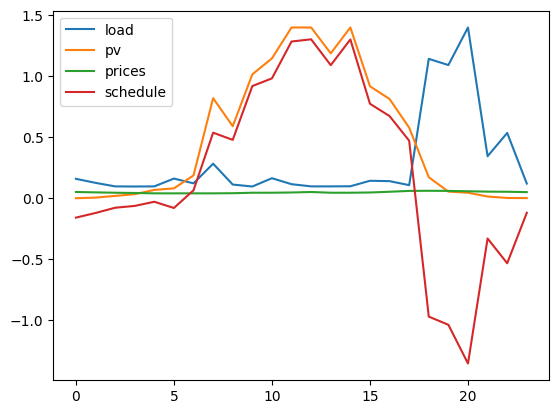

In [57]:
rl_actor.data[:24].plot()

In [58]:
algorithm = "new_start/24/1.4/norm_bank_reward_04-03-21-4"
best_timestep = 1600000
rl_actor.rl_environment = energy_env.EnergyEnv(rl_actor, market, horizon=24, training=False, energy_unit=0.001)

<Axes: >

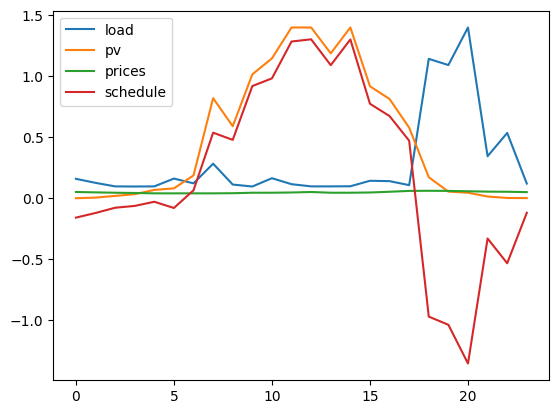

In [59]:
rl_actor.rl_environment.actor.data.plot()

In [3]:
algorithm = "new_start/24/1.4/norm_bank_reward_04-03-21-4"
best_timestep = 1600000
models_dir = f"rl-models/{algorithm}"
model_path = f"{models_dir}/{best_timestep}"

model = PPO.load(model_path)

/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


In [118]:
env = rl_actor.rl_environment
# load RL model to create market schedule prediction
models_dir = f"rl-models/{algorithm}"
model_path = f"{models_dir}/{best_timestep}"

model = PPO.load(model_path, env=env)

observation = env.reset()

action = model.predict(observation)
next_action = np.round(env.action_energy_values[action[0]], 3)

/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/home/local/RL-INSTITUT/daniel.ruedt/rli/BEST_local/simply/venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [63]:
action

(array([2098]), None)

In [62]:
next_action

array([-3.01])